Figures of merit for Clarence. He wants them to be in terms of contour area. This will require me to calculate contours again in this notebook.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats, interpolate

In [113]:
figsize = (8,6)
plt.rc('font', family='sans-serif')
plt.rc('axes', labelsize='x-large')
plt.rc('xtick', labelsize='large')
plt.rc('ytick', labelsize='large')
plt.rc('axes',titlesize='x-large')
plt.rcParams['figure.figsize'] = (8,6)
plt.rcParams['savefig.dpi'] = 200
plt.rcParams['savefig.bbox'] = 'tight'
plt.rcParams['savefig.pad_inches'] = 0.1
#print(plt.rcParams.keys())

In [39]:
def trim_data(xdata,ydata,CUT=0.9):
    
    if CUT == 1:
        CUT = 1-0.68
    elif CUT == 2:
        CUT = 1-0.95
    elif CUT == 3:
        CUT = 1-0.997
        
    
    npoints = len(xdata)

    values = np.vstack([xdata,ydata])
    kernel = stats.gaussian_kde(values)
    Z = np.reshape(kernel(values).T,xdata.shape)
    
    sort = [i for i in Z]
    sort.sort()
    cut = sort[int(CUT*npoints)]
    
    xcut = []
    ycut = []
    for i in range(npoints):
        if Z[i] >= cut:
            xcut.append(xdata[i])
            ycut.append(ydata[i])
    
    return np.array(xcut),np.array(ycut),cut

In [30]:
BLACK = sns.dark_palette('black',n_colors=1,as_cmap=True)
# This function plots the contours given the data and the cut from the kde
def contours(X, Y, cut, ax, x_bw=False, y_bw=False, gridsize=200):

    # default bandwidths
    if x_bw == False:
        x_bw = np.std(X)/3
    if y_bw == False:
        y_bw = np.std(Y)/2

    # contour outline
    cs = sns.kdeplot(X,Y,n_levels=[0,cut,1],cmap=BLACK,bw=[x_bw,y_bw],
                                                        gridsize=gridsize,ax=ax)
    # axis labels
    ax.set_xlabel('1n events',horizontalalignment='right',x=1.0)
    ax.set_ylabel('2n events',horizontalalignment='right', y=1.0)
    
    return cs

In [45]:
config = 2
dist_uncertainty = [0.1]
dist = [10]
eff = np.linspace(.3,.8,11)
sigmas = [1,2,3]

In [154]:
# load the prior data
prior = 'priors/prior_halo2_5kpc_truth.npy'
oneN,twoN = np.load(prior)
prior5_area = len(oneN)
prior = 'priors/prior_halo2_10kpc_truth.npy'
oneN,twoN = np.load(prior)
prior10_area = len(oneN)
prior = 'priors/prior_halo2_14kpc_distUncert10_truth.npy'
oneN,twoN = np.load(prior)
prior14_area = len(oneN)

In [120]:
areas5 = [[],[],[],[]]
d = 5

for e in eff:

    # load the unfolded data
    file = 'unfolded_data/halo'+str(config)+'_'+str(d)+\
            'kpc_unfolded_E'+str(int(100*e))+'.npy'
    oneN,twoN = np.load(file)

    areas5[0].append(e)

    for s in sigmas:
        # trim data and form contour
        x,y,cut = trim_data(oneN,twoN,s)
        ax = plt.axes()
        cs = contours(x,y,cut,ax)

        # calculate contour area
        # get the vertices
        p = cs.collections[0].get_paths()[0]
        x = p.vertices[:,0]
        y = p.vertices[:,1]
        # area with Green's theorem
        area = 0.5*np.sum(y[:-1]*np.diff(x) - x[:-1]*np.diff(y))
        area = np.abs(area)

        areas5[s].append(area/prior5_area)

        ax.remove()

In [47]:
areas10 = [[],[],[],[]]
d = 10

for e in eff:

    # load the unfolded data
    file = 'unfolded_data/halo'+str(config)+'_'+str(d)+\
            'kpc_unfolded_E'+str(int(100*e))+'.npy'
    oneN,twoN = np.load(file)

    areas10[0].append(e)

    for s in sigmas:
        # trim data and form contour
        x,y,cut = trim_data(oneN,twoN,s)
        ax = plt.axes()
        cs = contours(x,y,cut,ax)

        # calculate contour area
        # get the vertices
        p = cs.collections[0].get_paths()[0]
        x = p.vertices[:,0]
        y = p.vertices[:,1]
        # area with Green's theorem
        area = 0.5*np.sum(y[:-1]*np.diff(x) - x[:-1]*np.diff(y))
        area = np.abs(area)

        areas10[s].append(area/prior10_area)

        ax.remove()

In [155]:
areas14 = [[],[],[],[]]
d = 14

for e in eff:

    # load the unfolded data
    file = 'unfolded_data/halo'+str(config)+'_'+str(d)+\
            'kpc_distUncert10_unfolded_E'+str(int(100*e))+'.npy'
    oneN,twoN = np.load(file)

    areas14[0].append(e)

    for s in sigmas:
        # trim data and form contour
        x,y,cut = trim_data(oneN,twoN,s)
        ax = plt.axes()
        cs = contours(x,y,cut,ax)

        # calculate contour area
        # get the vertices
        p = cs.collections[0].get_paths()[0]
        x = p.vertices[:,0]
        y = p.vertices[:,1]
        # area with Green's theorem
        area = 0.5*np.sum(y[:-1]*np.diff(x) - x[:-1]*np.diff(y))
        area = np.abs(area)

        areas14[s].append(area/prior14_area)

        ax.remove()

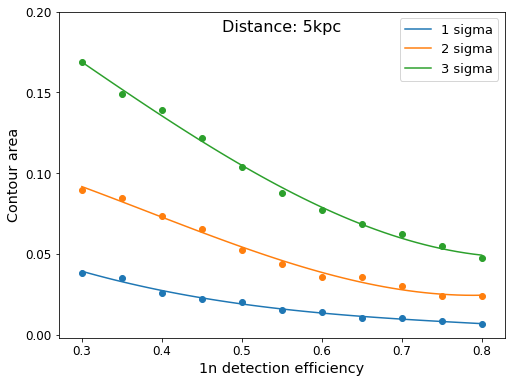

In [150]:
# 5kpc

fig1,ax1 = plt.subplots(1,1,figsize=(8,6))

for s in sigmas:
    t,c,k = interpolate.splrep(areas5[0],areas5[s],s=1)
    x = np.linspace(min(areas5[0]),max(areas5[0]))
    spline = interpolate.BSpline(t,c,k,extrapolate=False)
    ax1.plot(x,spline(x),label=str(s)+' sigma')
    ax1.scatter(areas5[0],areas5[s])
    
ax1.set_xlabel("1n detection efficiency")
ax1.set_ylabel("Contour area")
ax1.set_yticks([0,0.05,0.1,0.15,0.2])

ax1.legend(prop={'size': 13})

ax1.text(0.5,0.93,'Distance: 5kpc',fontsize=16,transform=ax1.transAxes,ha='center',va='bottom')

#fig1.savefig('figure_of_merit_halo2_5kpc.png')

plt.show()

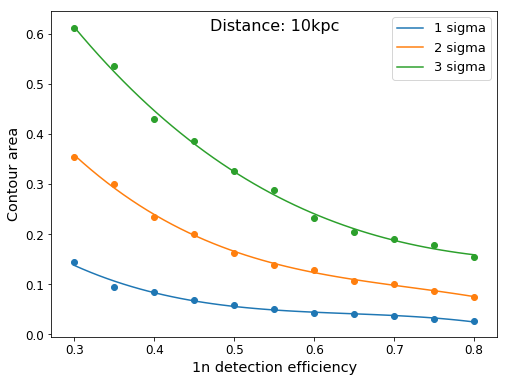

In [125]:
# 10kpc

fig2,ax2 = plt.subplots(1,1,figsize=(8,6))

for s in sigmas:
    t,c,k = interpolate.splrep(areas10[0],areas10[s],s=1)
    x = np.linspace(min(areas10[0]),max(areas10[0]))
    spline = interpolate.BSpline(t,c,k,extrapolate=False)
    ax2.plot(x,spline(x),label=str(s)+' sigma')
    ax2.scatter(areas10[0],areas10[s])
    
ax2.set_xlabel("1n detection efficiency")
ax2.set_ylabel("Contour area")

ax2.legend(prop={'size': 13})

ax2.text(0.5,0.93,'Distance: 10kpc',fontsize=16,transform=ax2.transAxes,ha='center',va='bottom')

#fig2.savefig('figure_of_merit_halo2_10kpc.png')

plt.show()

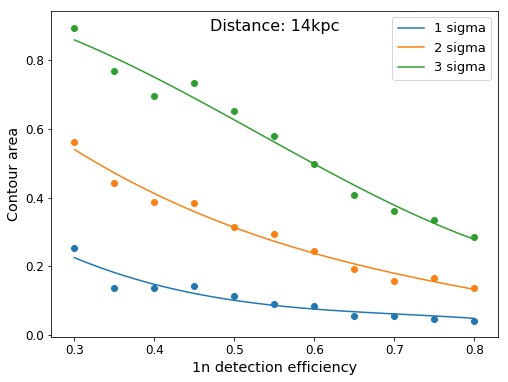

In [186]:
# 14kpc
areas14[1][-1] = 0.06
# 0.011813475853066876
fig3,ax3 = plt.subplots(1,1,figsize=(8,6))

for s in sigmas:
    t,c,k = interpolate.splrep(areas14[0],areas14[s],s=1)
    x = np.linspace(min(areas14[0]),max(areas14[0]))
    spline = interpolate.BSpline(t,c,k,extrapolate=True)
    ax3.plot(x,spline(x),label=str(s)+' sigma')
    areas14[1][-1] = 0.04
    ax3.scatter(areas14[0],areas14[s])
    
ax3.set_xlabel("1n detection efficiency")
ax3.set_ylabel("Contour area")

ax3.legend(prop={'size': 13})

ax3.text(0.5,0.93,'Distance: 14kpc',fontsize=16,transform=ax3.transAxes,ha='center',va='bottom')

#fig3.savefig('figure_of_merit_halo2_14kpc.png')

plt.show()